In [13]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, Activation, MaxPooling2D, BatchNormalization
from keras import optimizers, regularizers
from keras.optimizers import SGD

In [14]:
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [15]:
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

col = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5':'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

In [16]:
def create_model():
    model = Sequential()
    # Use Batch Normalization for every conv and dense layers
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (160, 120, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.33))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation = 'softmax')) 
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

In [17]:
reconstructed_model = models.load_model('weights_best.h5')

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
texting - right


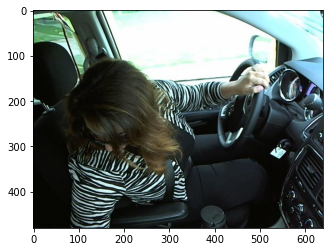

In [18]:
image_path = "img_100025.jpg"
image = load_img(path=image_path, color_mode="grayscale",
                                              target_size=(160, 120))
input_arr = img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = reconstructed_model.predict(input_arr)
print(predictions)
print(col[labels[np.argmax(predictions[0])]])

#col
image = read_image(image_path)
plt.imshow(image)
plt.show()

In [7]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from keras import applications
from keras.models import Sequential
from keras.layers import Dropout,Flatten, Dense
import operator


class VGG16(object):
    def __init__(self):
        # build the VGG16 network  
        self.base_model = applications.VGG16(include_top=False, weights='imagenet')  
        self.__loaded_model()
    
    def __loaded_model(self, shape=(7, 7, 512), top_model_weights_path="models/_top_model_weights.h5"):
        # build top model  
        self.model = self.create_top_model("softmax", shape)
        self.model.load_weights(top_model_weights_path) 
    
    
    def create_top_model(self, final_activation, input_shape, num_classes = 10):
        model = Sequential()  
        model.add(Flatten(input_shape=input_shape))  
        model.add(Dense(256, activation='relu'))  
        model.add(Dropout(0.5))  
        model.add(Dense(num_classes, activation=final_activation)) # sigmoid to train, softmax for prediction
        return model

    def get_prediction_from_image(self, img_path):
        class_labels = ['safe_driving', 'texting_right', 'talking_on_phone_right', 'texting_left', 'talking_on_phone_left',
                    'operating_radio', 'drinking', 'reaching_behind', 'doing_hair_makeup', 'talking_to_passanger']

        target_size=(224,224)

        # prepare image for classification using keras utility functions
        image = load_img(img_path, target_size=target_size)
        image = img_to_array(image) # convert from PIL Image to NumPy array
        image /= 255
        # the dimensions of image should now be (150, 150, 3)

        # to be able to pass it through the network and use batches, we want it with shape (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        # print(image.shape)

        bottleneck_prediction = self.base_model.predict(image) 
        print(bottleneck_prediction.shape[1:])
        
        # use the bottleneck prediction on the top model to get the final classification  
        class_predicted = self.model.predict_classes(bottleneck_prediction) 

        probs = self.model.predict(bottleneck_prediction) 
        decoded_predictions = dict(zip(class_labels, probs[0]))
        decoded_predictions = sorted(decoded_predictions.items(), key=operator.itemgetter(1), reverse=True)

        count = 1
        top_prediction, score = decoded_predictions[:1][0]
        return top_prediction, score


vgg_obj = VGG16()
vgg_obj.get_prediction_from_image("img_100121.jpg")

(7, 7, 512)


('operating_radio', 1.0)